In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "2"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [3]:

################################### SETTINGS ###################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 for full dataset
train, val, test = 75000, 10000, 15000
# train, val, test = 1000000, 200000, 200000
use_pids = True

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 50
batch_size = 500

################################################################################

In [4]:
# load data
X, y = qg_jets.load(train + val + test)

# convert labels to categorical
Y = to_categorical(y, num_classes=2) #one hot encoding!

print('Loaded quark and gluon jets')

Loaded quark and gluon jets


In [5]:
X[:,:,3].astype(int).reshape((X.shape[0]*X.shape[1]))

array([  22,   22, -211, ...,    0,    0,    0])

In [6]:
PID2FLOAT_MAP = {22: 1.4,
                 211: .1, -211: .2,
                 321: .3, -321: .4,
                 130: .5,
                 2112: .6, -2112: .7,
                 2212: .8, -2212: .9,
                 11: 1.0, -11: 1.1,
                 13: 1.2, -13: 1.3,
                 0: 0}

def remap_pids_max(events, pid_i=3, error_on_unknown=True):
    """Remaps PDG id numbers to small floats for use in a neural network.
    `events` are modified in place and nothing is returned.
    **Arguments**
    - **events** : _numpy.ndarray_
        - The events as an array of arrays of particles.
    - **pid_i** : _int_
        - The column index corresponding to pid information in an event.
    - **error_on_unknown** : _bool_
        - Controls whether a `KeyError` is raised if an unknown PDG ID is
        encountered. If `False`, unknown PDG IDs will map to zero.
    """
    if events.ndim == 3:
        pids = events[:,:,pid_i].astype(int).reshape((events.shape[0]*events.shape[1]))
        if error_on_unknown:
            events[:,:,pid_i] = np.asarray([PID2FLOAT_MAP[pid]
                                            for pid in pids]).reshape(events.shape[:2])
        else:
            events[:,:,pid_i] = np.asarray([PID2FLOAT_MAP.get(pid, 0)
                                            for pid in pids]).reshape(events.shape[:2])
    else:
        if error_on_unknown:
            for event in events:
                event[:,pid_i] = np.asarray([PID2FLOAT_MAP[pid]
                                             for pid in event[:,pid_i].astype(int)])
        else:
            for event in events:
                event[:,pid_i] = np.asarray([PID2FLOAT_MAP.get(pid, 0)
                                             for pid in event[:,pid_i].astype(int)])

In [7]:
# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids_max(X, pid_i=3)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

Finished preprocessing


In [8]:
X.shape, Phi_sizes, F_sizes

((100000, 139, 4), (100, 100, 128), (100, 100, 100))

In [9]:
# do train/val/test split 
(X_train, X_val, X_test, Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes) #input dim is 4 for number of types of data being taken into account

# train model
pfn.fit(X_train, Y_train,
        epochs=num_epoch, #familiar!
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)#familiar

# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1]) #familiar

Done train/val/test split
Model summary:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
_____________________________________________________

In [10]:
# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()

# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)


PFN AUC: 0.8842124018721785



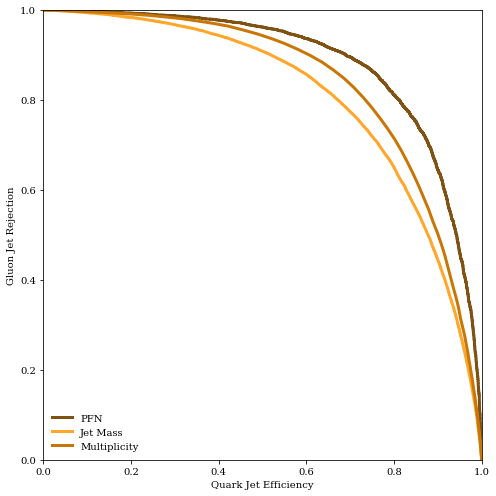

In [11]:
# some nicer plot settings 
plt.rcParams['figure.figsize'] = (7,7)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='xkcd:medium brown', label='PFN', linewidth=3)
plt.plot(mass_tp, 1-mass_fp, '-', color='xkcd:mango', label='Jet Mass', linewidth=3)
plt.plot(mult_tp, 1-mult_fp, '-', color='xkcd:dirty orange', label='Multiplicity', linewidth=3)

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()